# Vehicle Detection by Akash Chauhan

### This is the 5th project for the term1 of Self Driving Car Course by Udacity.

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

## Lets start with the first step and then we will follow other steps creating a pipeline in the process

In [1]:
# Importing the required libraries
import cv2
import glob
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import time
from tqdm import tqdm

from random import shuffle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

/anaconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Loading the Data

In [2]:
car_images = glob.glob("data/vehicles/**/*.*")
noncar_images = glob.glob("data/non-vehicles/**/*.*")
print(len(car_images), ' images of vehicles')
print(len(noncar_images), ' images of non-vehicles')
sample_img = mpimg.imread(car_images[0])
print(sample_img.shape, ' image shape')

# Shuffle the images
shuffle(car_images)
shuffle(noncar_images)

8792  images of vehicles
8968  images of non-vehicles
(64, 64, 3)  image shape


### Data Visualization

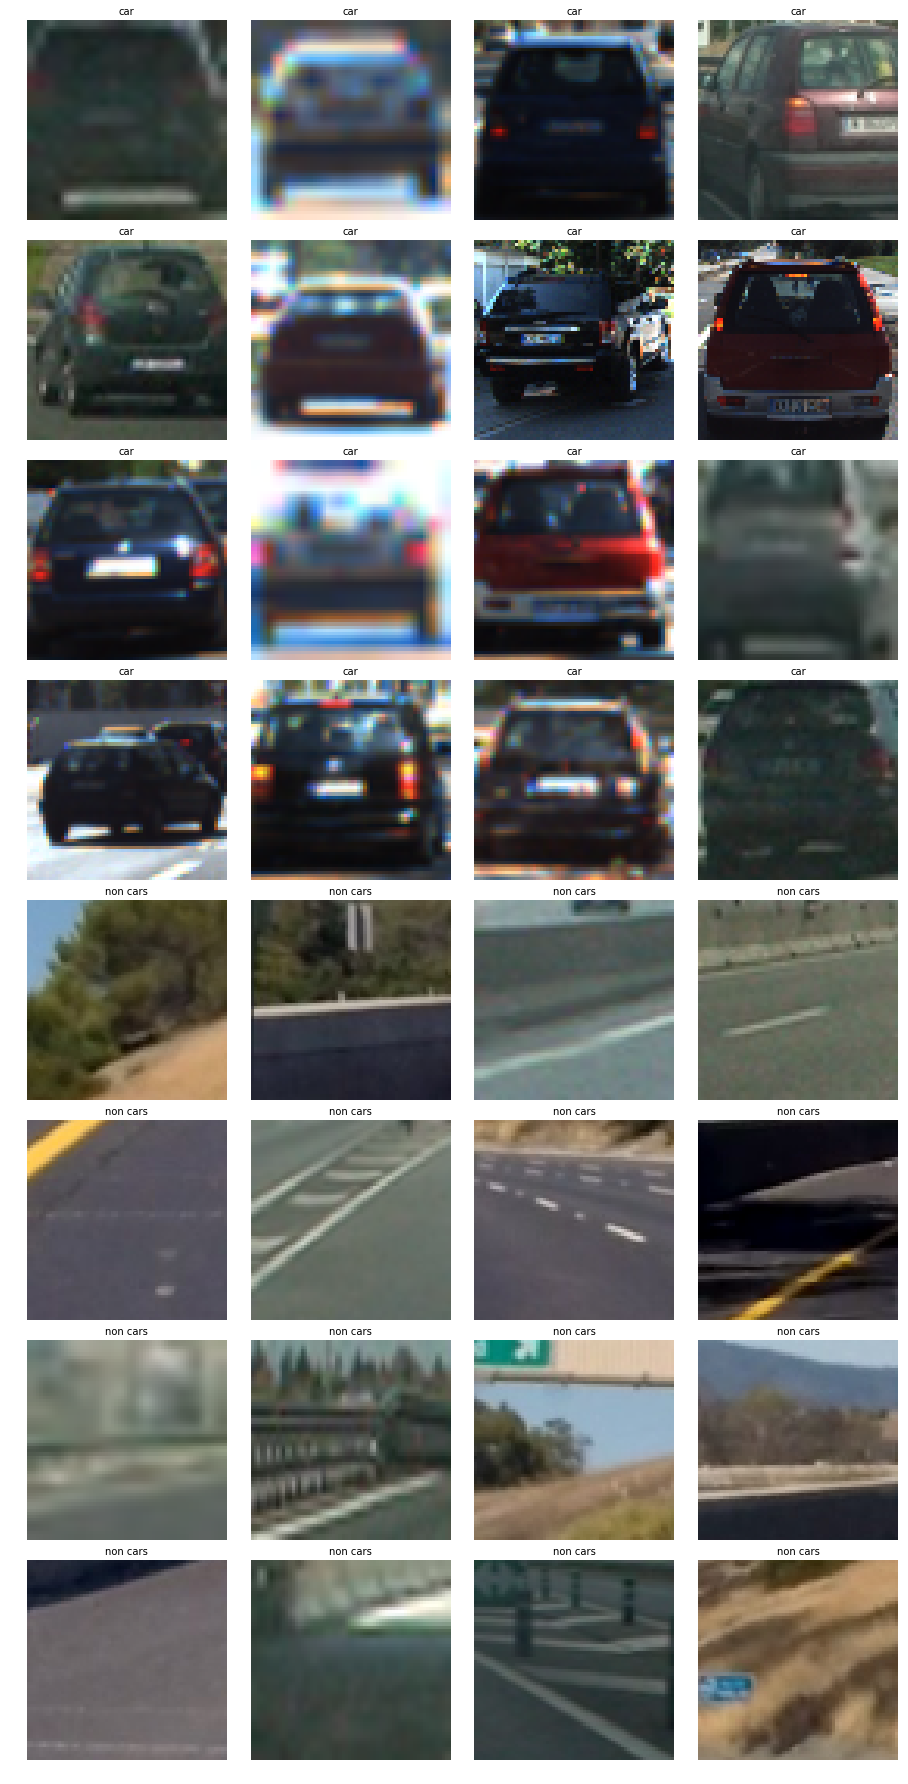

In [3]:
fig, axes = plt.subplots(8,4, figsize=(16, 32))
fig.subplots_adjust(hspace = .1, wspace=.01)
axes = axes.ravel()

# Iterate through the images and display

# Display the car images
for i in np.arange(16):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].set_title('car', fontsize=10)
    axes[i].imshow(img)
    
# Display the non car images
for i in np.arange(16,32):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].set_title('non cars', fontsize=10)
    axes[i].imshow(img)


## Histogram of Oriented Gradients (HOG) conversion

In [4]:
# HOG funciton from sklearn.features
# hog_features, hog_image = hog(img, orientations=orient,
#                           pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                           cells_per_block=(cell_per_block, cell_per_block), 
#                           visualise=True, feature_vector=False,
#                           block_norm="L2-Hys")

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

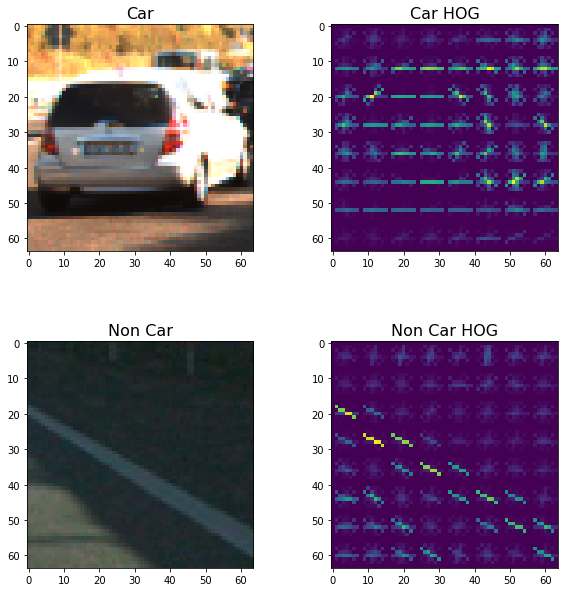

In [5]:
# Hog visualization with sample images

pix_per_cell = 8
cell_per_block = 2
orient = 9

car_img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
_, car_hog = get_hog_features(car_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[np.random.randint(0,len(car_images))])
_, noncar_hog = get_hog_features(noncar_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize 
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.subplots_adjust(hspace = .4, wspace=.2)
axes = axes.ravel()
titles = ['Car', 'Car HOG', 'Non Car', 'Non Car HOG']
images = [car_img, car_hog, noncar_img, noncar_hog]
for i in range(4):
    axes[i].imshow(images[i])
    axes[i].set_title(titles[i], fontsize=16)

In [6]:
# Computing Histogram Features
def color_histogram(img, nbins=32, bins_range=(0, 256), vis=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((channel1_hist[0],
                                    channel2_hist[0],
                                    channel3_hist[0]))
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

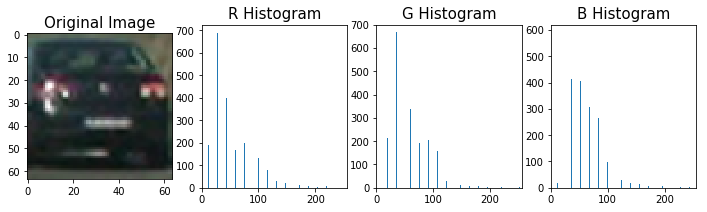

In [7]:
# Random index
index = np.random.randint(0, len(car_images))
# Read in the image
img = cv2.imread(car_images[index])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Compute color histogram features of the test image
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_histogram(image, vis=True)
# Plot the examples
fig = plt.figure(figsize=(12,3));

plt.subplot(141)
plt.imshow(image)
plt.title('Original Image', fontsize=15)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=15);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=15);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=15);

plt.savefig('output_images/color_hist_vis.png', bbox_inches="tight")

In [8]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert to new color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

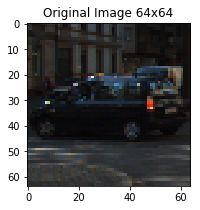

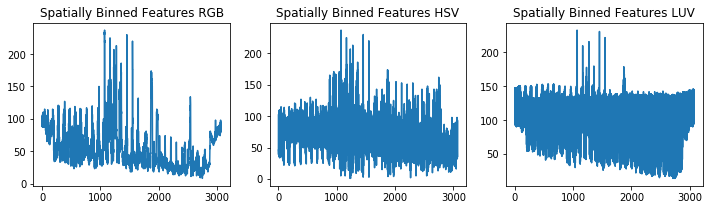

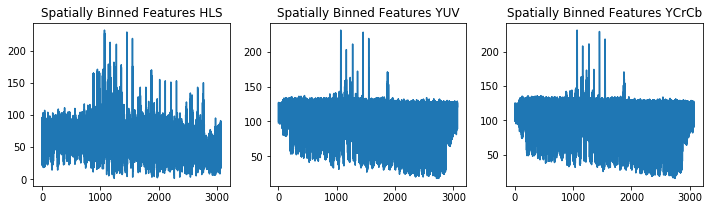

In [9]:
feature_vec1 = bin_spatial(image, color_space='RGB', size=(32, 32))
feature_vec2 = bin_spatial(image, color_space='HSV', size=(32, 32))
feature_vec3 = bin_spatial(image, color_space='LUV', size=(32, 32))
feature_vec4 = bin_spatial(image, color_space='HLS', size=(32, 32))
feature_vec5 = bin_spatial(image, color_space='YUV', size=(32, 32))
feature_vec6 = bin_spatial(image, color_space='YCrCb', size=(32, 32))

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
index = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[index])
small_image = cv2.resize(image, (16, 16))

# Plot features
fig = plt.figure(figsize=(12,3))
plt.subplot(111)
plt.imshow(image)
plt.title('Original Image 64x64')
plt.savefig('output_images/bin_spatial1.png', bbox_inches="tight")

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(feature_vec1)
plt.title('Spatially Binned Features RGB')
plt.subplot(132)
plt.plot(feature_vec2)
plt.title('Spatially Binned Features HSV')
plt.subplot(133)
plt.plot(feature_vec3)
plt.title('Spatially Binned Features LUV')
plt.savefig('output_images/bin_spatial2.png', bbox_inches="tight")

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(feature_vec4)
plt.title('Spatially Binned Features HLS')
plt.subplot(132)
plt.plot(feature_vec5)
plt.title('Spatially Binned Features YUV')
plt.subplot(133)
plt.plot(feature_vec6)
plt.title('Spatially Binned Features YCrCb')
plt.savefig('output_images/bin_spatial3.png', bbox_inches="tight")

In [10]:
# Function to extract features from a list of images
# This function calls bin_spatial() and color_histogram()
def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) # idea for the progress came from "nhiddink"
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_histogram(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [11]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

print("Car features extraction starts,..")
%time car_features = extract_features(car_images, color_space='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
print("Car features extraction completed.")

print("Non Car features extraction starts,..")
%time noncar_features = extract_features(noncar_images, color_space='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
print("Non Car features extraction completed.")

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print("SVC training starts,..\n")
%time svc.fit(X_train, y_train)
print("SVC training completed.\n")
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...\n')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Predictions: ', svc.predict(X_test[0:n_predict]))
print('Labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

  0%|          | 31/8792 [00:00<00:28, 302.48it/s]

Car features extraction starts,..


  0%|          | 28/8968 [00:00<00:32, 277.75it/s]

CPU times: user 21.8 s, sys: 2.97 s, total: 24.8 s
Wall time: 29.5 s
Car features extraction completed.
Non Car features extraction starts,..


100%|██████████| 8968/8968 [00:27<00:00, 320.41it/s]


CPU times: user 20.8 s, sys: 2.78 s, total: 23.5 s
Wall time: 28 s
Non Car features extraction completed.
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4932
SVC training starts,..

CPU times: user 13.2 s, sys: 366 ms, total: 13.6 s
Wall time: 13.6 s
SVC training completed.

13.6 Seconds to train SVC...

Test Accuracy of SVC =  0.9654
Predictions:  [0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
Labels:  [0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
0.00131 Seconds to predict 10 labels with SVC


### Sliding Window Implementation

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

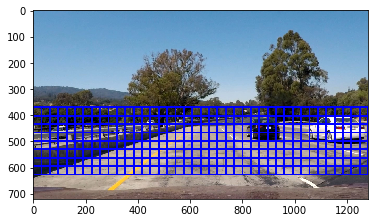

In [14]:
test_image = mpimg.imread('./test_images/test1.jpg')

windows =  slide_window(test_image,
                        x_start_stop=[None, None],
                        y_start_stop=[370, 656], #tune the parameters
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(test_image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [15]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_histogram(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [16]:

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [17]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [18]:
car_features = extract_features(car_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
noncar_features = extract_features(noncar_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,
                                                    random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
# Check the prediction time for a single sample
t=time.time()


100%|██████████| 8968/8968 [00:38<00:00, 234.71it/s]


Using: 10 orientations, 8 pixels per cell and 2 cells per block
Feature vector length: 9144
7.36 Seconds to train SVC...
Test Accuracy of SVC = 98.85%


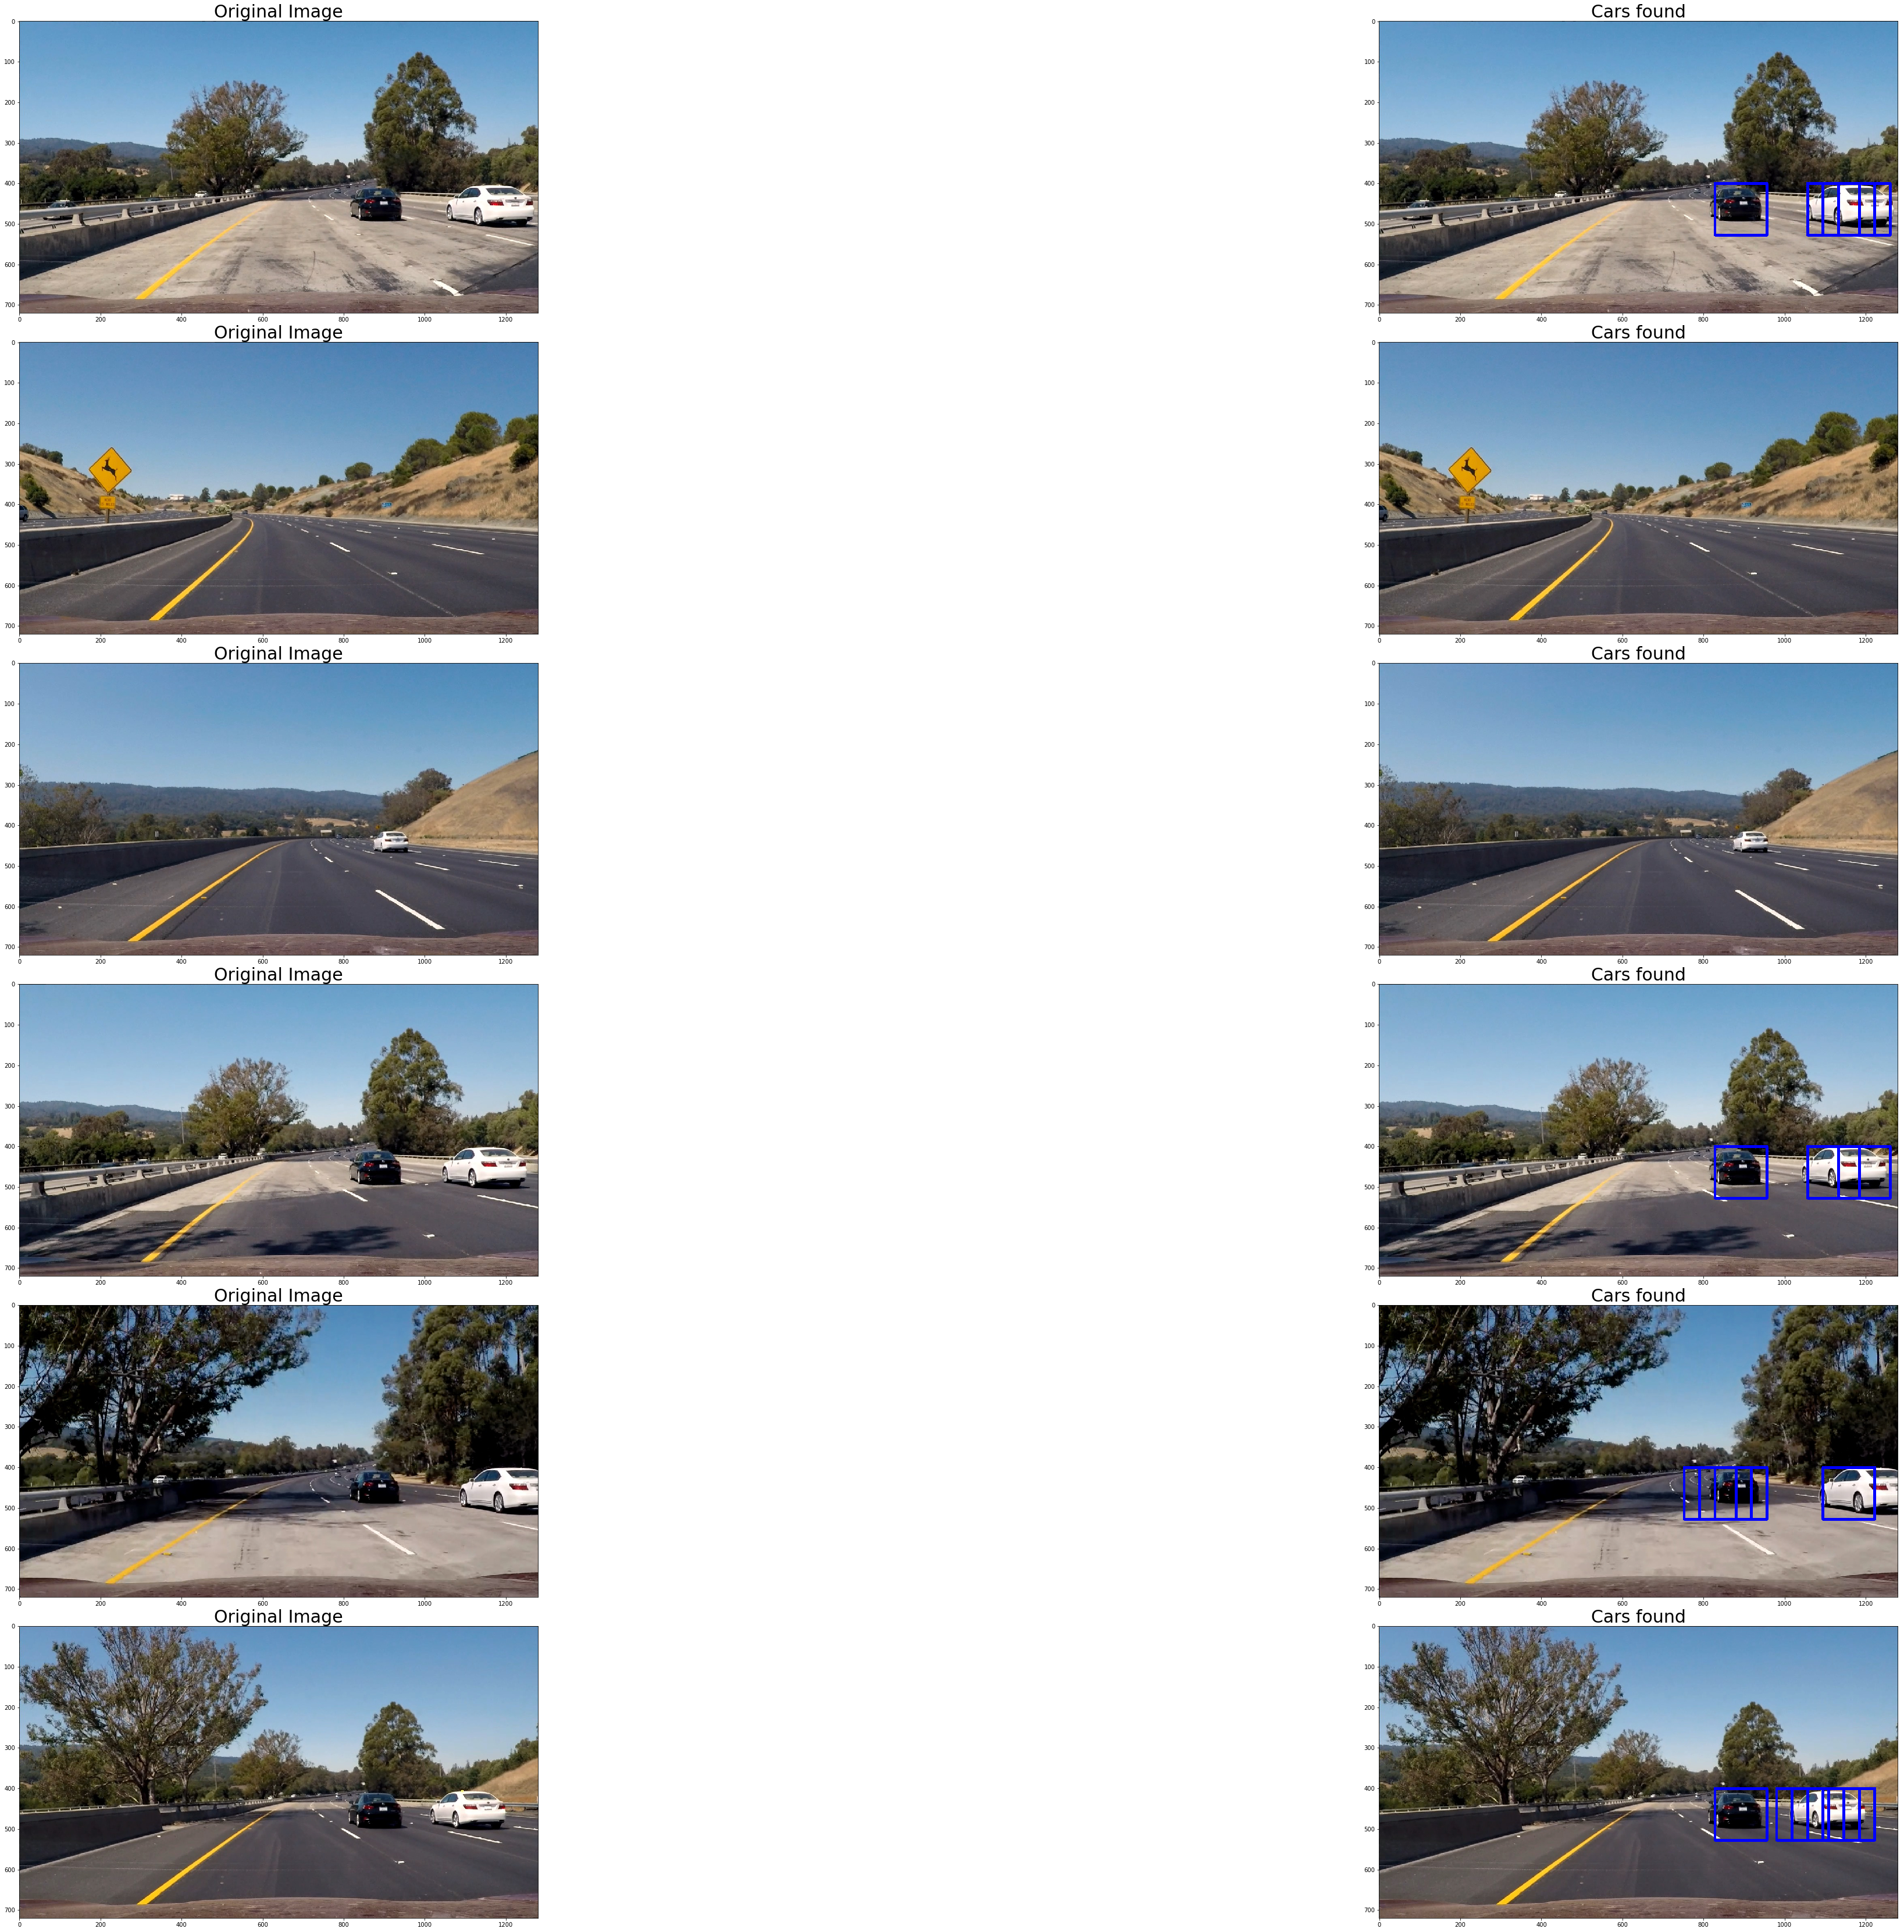

In [19]:
fig, axes = plt.subplots(6, 2, figsize=(80,60))
fig.subplots_adjust(hspace = .1, wspace=.1)
axes = axes.ravel()
for i in range(6):
    
    fname = 'test_images/test{}.jpg'.format(i+1)
    image = mpimg.imread(fname)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows =  slide_window(image,
                            x_start_stop=[600, None],
                            y_start_stop=[400, 656], #tune the parameters
                            xy_window=(128,128),
                            xy_overlap=(.7,.7))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
    
    axes[2*(i+1)-2].imshow(draw_image)
    axes[2*(i+1)-2].set_title('Original Image', fontsize=30)
    axes[2*(i+1)-1].imshow(window_img)
    axes[2*(i+1)-1].set_title('Cars found', fontsize=30)
    plt.savefig('output_images/windows.png', bbox_inches="tight")                                         

### Add HeatMap

In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[int(box[0][1]):int(box[1][1]), int(box[0][0]):int(box[1][0])] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [21]:
# Apply treshhold to the heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [23]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

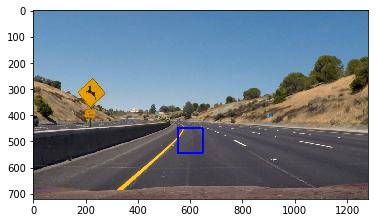

In [24]:
img = mpimg.imread('./test_images/test2.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_histogram(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

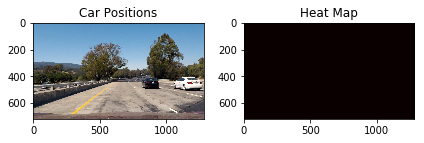

In [25]:
# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

ystart = 400
ystop = 656
scale = 1.5
    
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

size of bboxs  0


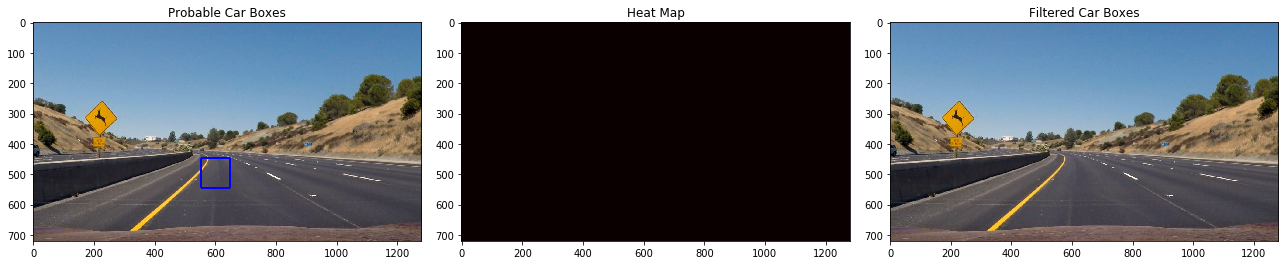

In [26]:
for i in range(2,3):
    
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    bboxs = []

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64

    ystart = 400
    ystop = 656
    scale = 1.5
    out_img, bbox1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    ystart = 380
    ystop = 550
    scale = 1.0
    out_img2, bbox2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    for box in bbox1:
        bboxs.append(box)
    for box in bbox2:
        bboxs.append(box)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxs)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,11)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    bboxs = []
    bbox1 = []
    bbox2 = []

    fig = plt.figure(figsize=(18,9))
    
    # Drawing all the probable bboxes
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('Probable Car Boxes')
    
    # Drawing the heatmap
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Filtered Car Boxes')
    fig.tight_layout()

In [27]:
def process_image(image):
    bboxs = []

    orient = 10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64

    ystart = 400
    ystop = 600
    scale = 1.5
    out_img, bbox1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    ystart = 380
    ystop = 550
    scale = 1.0
    out_img2, bbox2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 400
    ystop = 656
    scale = 2.0
    out_img3, bbox3 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 300
    ystop = 456
    scale = 0.5
    out_img4, bbox5 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    for box in bbox1:
        bboxs.append(box)
    for box in bbox2:
        bboxs.append(box)
    for box in bbox3:
        bboxs.append(box)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxs)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

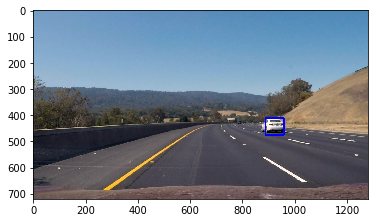

In [28]:
for i in range(3,4):
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    processed_image = process_image(image)
    plt.imshow(processed_image)

## Video Processing

### First Attempting the test video

In [29]:
test_output = "test_video_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:42<00:02,  2.70s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 41s, sys: 2.82 s, total: 1min 44s
Wall time: 1min 43s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output.mp4"))

### Attempting the Project Video

In [ ]:
project_output = "project_video_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 36%|███▌      | 451/1261 [33:48<1:00:43,  4.50s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))